# Estimating the Flare Rate for TIC 272272592
___ 

### 1.0 - Loading Full-Cadence Lightcurve Data

In [1]:
import os, sys
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.table import Table
from lightkurve.search import search_lightcurve

plt.rcParams['font.size'] = 20
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20


In [2]:
target_id = 272272592 # 
search_result = lk.search_lightcurve(f'tic {target_id}', author='SPOC')
sector = [s.split(" ")[-1] for s in search_result.mission] # available sectors

In [3]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,272272592,0.0
1,TESS Sector 15,2019,SPOC,120,272272592,0.0


In [4]:
LC = [search_lightcurve(target=f'tic {target_id}', mission='TESS', sector=f"{int(ss)}",
                        author='SPOC').download() for ss in sector]
LC = [llc.remove_nans() for llc in LC]

Text(0.5, 1.0, 'Stiched lightcurve TIC 272272592')

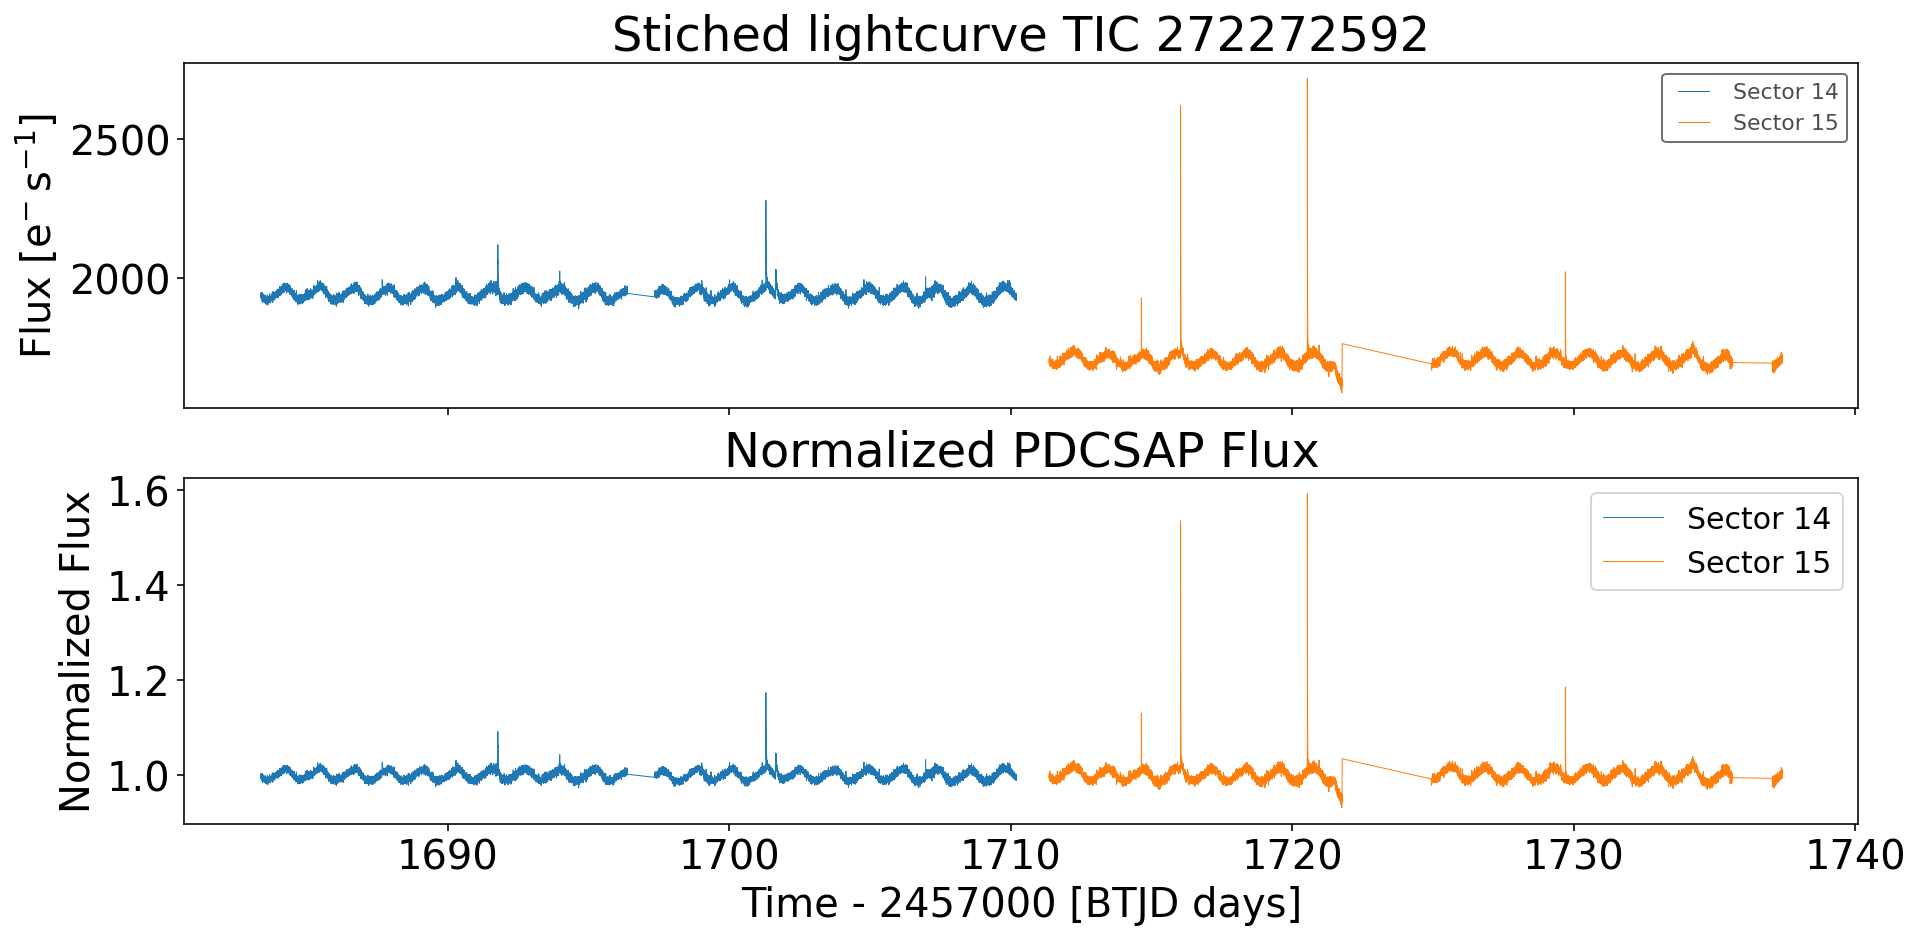

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,7), sharex=True)
for i in range(len(LC)):
    LC[i].plot(ax=ax[0], label=f"Sector {sector[i]}", xlabel='')
    LC[i].normalize().plot(ax=ax[1], label=f"Sector {sector[i]}", title='HEEEE')

    
plt.legend(fontsize=15)
ax[1].set_title("Normalized PDCSAP Flux")
ax[0].set_title(f"Stiched lightcurve TIC {target_id}")

In [6]:
def stich_lcs(lc_list, mode='raw'):
    """Function retuns stiched numpy arrays (i.e values) from each sector.
    
    Input: 
    ------
    lc_list (list): list of lightkurve targets
    mode (str): default mode is raw where it will return the flux in e-/s units. Normalized will normalize the lc to 1
    """
    
    
    if mode=='raw':
        return (np.concatenate([lc_list[j].time.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].flux.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].flux_err.value for j in range(len(lc_list))]))
    
    elif mode=='normalized':
        return (np.concatenate([lc_list[j].normalize().time.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].normalize().flux.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].normalize().flux_err.value for j in range(len(lc_list))]))
    
    

In [7]:
# Stich light curve data
time0, flux0, flux_err0 = stich_lcs(LC, mode='raw') # raw counts
time, flux, flux_err = stich_lcs(LC, mode='normalized')# normalized

## Flare Identification Using `Stella`

In [8]:
sys.path.insert(1, '/Users/andytzanidakis/stella/')
import stella

In [9]:
def predict_flares(data_time, data_flux, data_flux_err, targ_id, ensembling=True, model_index=0, flare_thesh_prob=0.75, out_dir='.'):
    """This function will take the the light curve data (i.e time, flux, and flux_err)
    and using stella, it will return an astropy.table containing the identified flares given 
    a flare_threshold_probability parameter. 
    
    ensembling: True (will combine all available models via stella.DownloadSets()) trained on TESS data via
    
                If ensembling==False, function will use model index. Current available trained models:
                    0) .stella/models/hlsp_stella_tess_ensemblemodel_s004_tess_v0
                    1) .stella/models/hlsp_stella_tess_ensemblemodel_s005_tess_v0
                    2) .stella/models/hlsp_stella_tess_ensemblemodel_s018_tess_v0
                    3) .stella/models/hlsp_stella_tess_ensemblemodel_s028_tess_v0
                    4) .stella/models/hlsp_stella_tess_ensemblemodel_s029_tess_v0
                    5) .stella/models/hlsp_stella_tess_ensemblemodel_s038_tess_v0
                    6) .stella/models/hlsp_stella_tess_ensemblemodel_s050_tess_v0
                    7) .stella/models/hlsp_stella_tess_ensemblemodel_s077_tess_v0
                    8) .stella/models/hlsp_stella_tess_ensemblemodel_s078_tess_v0
                    9) .stella/models/hlsp_stella_tess_ensemblemodel_s080_tess_v0
    
    flare_thresh_prob (float): Flare rate proability treshold, range from >0 to 
    out_dir (str): output directory. Deafult is '.'
    """
    # Define CNN via Stella
    cnn = stella.ConvNN(output_dir='.')
    
    # Download trained TESS models - Feinstein et al. (2020)
    ds = stella.DownloadSets()
    ds.download_models()
    my_models = ds.models # list of all models
    
    if ensembling: 
        # ensembling will combine all models and remove duplicate identified flares
        
        my_flare_table = Table(names=('Target_ID', 'tpeak', 'amp', 'ed_s', 'rise', 'fall', 'prob')) # final table
        for i in range(len(my_models)):
            cnn.predict(modelname=my_models[i],
                   times=data_time,
                    fluxes=data_flux,
                    errs=data_flux_err)
            
            # Fit flares
            fit_flares = stella.FitFlares(id=[targ_id],
                                      time=[data_time],
                                      flux=[data_flux], 
                                      flux_err=[data_flux_err],
                                      predictions=[cnn.predictions[0]])
            
            fit_flares.identify_flare_peaks(threshold=flare_thesh_prob) # identify flares
            
            f_table0 = fit_flares.flare_table # flare table
            
            for j in range(len(f_table0)): # append each entry to final table
                my_flare_table.add_row(f_table0[j])
        
        # return the merged tables by only those with unique tpeak
        return my_flare_table[np.unique(my_flare_table['tpeak'], return_index=True)[1]]       
        
    else: 
        # Use the model_index selection for a single model
        cnn.predict(modelname=my_models[model_index],
                   times=data_time,
                    fluxes=data_flux,
                    errs=data_flux_err)
        
        # Fit flares
        fit_flares = stella.FitFlares(id=[targ_id],
                                      time=[data_time],
                                      flux=[data_flux], 
                                      flux_err=[data_flux_err],
                                      predictions=[cnn.predictions[0]])
        
        fit_flares.identify_flare_peaks(threshold=flare_thesh_prob) # identify flares
        
        return fit_flares.flare_table

### Comparing Stellar Flare Rates for `ensamble` vs singular models using the probability threshold parameters

In [10]:
prob_step = np.linspace(0.1, 0.99, 20)

# how many falres do we get as we go from softer to harder probability criteria
nn = [len(predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=True, flare_thesh_prob=p)) for p in prob_step]

nn0 = [len(predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=False,model_index=0, flare_thesh_prob=p)) for p in prob_step]

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]2021-07-07 14:23:24.552577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-07 14:23:24.553950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanida

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


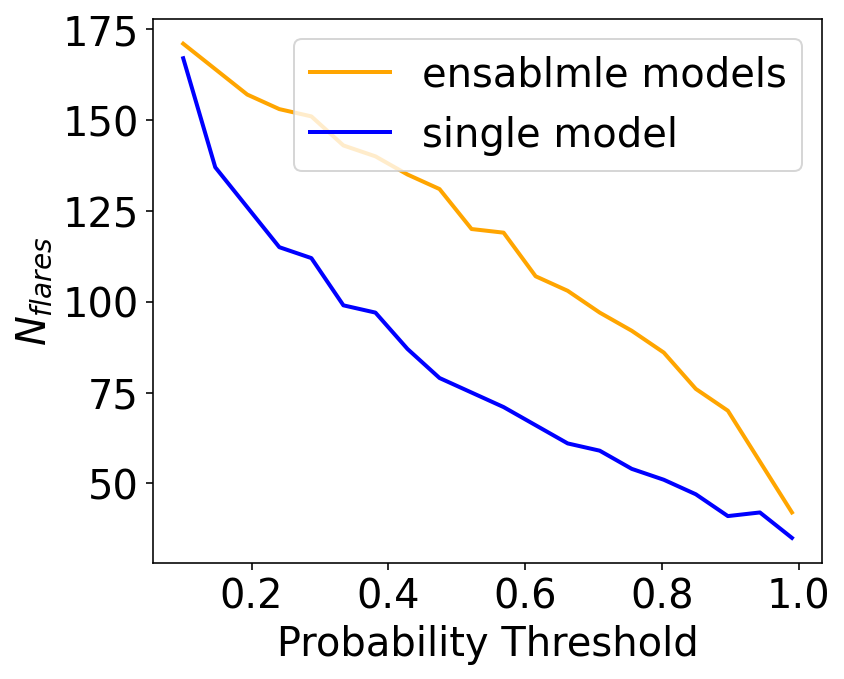

In [12]:
plt.figure(figsize=(6,5))
plt.plot(prob_step, nn, color='orange', lw=2, label='ensablmle models')
plt.plot(prob_step, nn0, color='blue', lw=2, label='single model')
plt.xlabel("Probability Threshold")
plt.ylabel("$N_{flares}$")
plt.legend()